# Stroke Prediction

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

In this project, we'll be exploring a dataset available on [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) containing the information on strokes. This dataset will be used to predict whether a patient is likely to have a stroke based on various input parameters.

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from opfython.models.supervised import SupervisedOPF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import logging
logging.disable()

In [2]:
sns.set(style="darkgrid")
sns.set_palette("bright")

## 1. Loading Dataset
___

In [3]:
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
print(f"> There are {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

> There are 5110 rows and 12 columns.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**Attribute Information**:

- **id**: unique identifier;
- **gender**: gender (Male, Female or Other);
- **age**: age of the person;
- **hypertension**: person has hypertension (1 or 0);
- **heart_disease**: person has any heart disease (1 or 0);
- **ever_married**: person has been married (1 or 0);
- **work_type**: nature of work place (children, Govt_jov, Never_worked, Private or Self-employed);
- **Residence_type**: Residence type of the individual (Rural or Urban);
- **avg_glucose_level**: average glucose level in blood for the individual;
- **bmi**: body mass index of the individual;
- **smoking_status**: current smoking status (formerly smoked, never smoked, smokes or Unknown);
- **stroke**: person suffered heart attack (1 or 0).

## 2. Data Cleaning
___

### Missing data

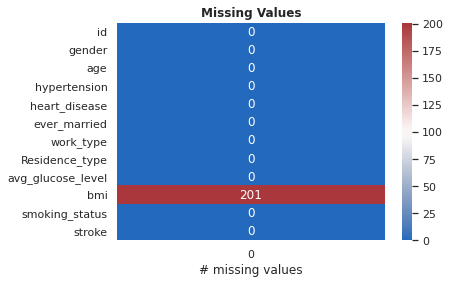

In [4]:
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='vlag')
plt.title('Missing Values', fontweight='bold')
ax.set_xlabel('# missing values')
plt.show()

There are `201` missing values in the `bmi` column.


In this case we'll be using **KNNImputer** to complete the missing values (filling them with the mean value of the `5` nearest neighbors).

In [5]:
# Selecting columns we'll be using in the knnimputer
imputer_cols = ['age', 'avg_glucose_level', 'bmi']
df_imputer = df[imputer_cols].copy()

# Data Normalization
scaler = StandardScaler()
df_imputer = scaler.fit_transform(df_imputer)

# Imputing missing data
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_imputer)

# Reverting data normalization
df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), columns=imputer_cols)
df_imputed

,age,avg_glucose_level,bmi
0,67.0,228.69,36.60
1,61.0,202.21,31.14
2,80.0,105.92,32.50
3,49.0,171.23,34.40
4,79.0,174.12,24.00
...,...,...,...
5105,80.0,83.75,27.08
5106,81.0,125.20,40.00
5107,35.0,82.99,30.60
5108,51.0,166.29,25.60


In [6]:
# Adding the new data (imputed data)
df['bmi'] = df_imputed['bmi']

In [7]:
print(f"> Missing values after data cleaning: {sum(df.isna().sum())}")

> Missing values after data cleaning: 0


## 3. Exploratory Analysis
___

This dataset is **highly imbalanced**. There are only **249** strokes cases in our whole dataset (**4,87%**).

In [8]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

### 3.1 Visualization of Numeric Variables

In order to visualize the distribution of numeric variables, we'll be splitting the dataframe into **Stroke** and **No Stroke**

In [9]:
# Splitting cases in stroke and no-stroke
df_stroke = df[df['stroke'] == 1]
df_nostroke = df[df['stroke'] == 0]

#### Age Distribution

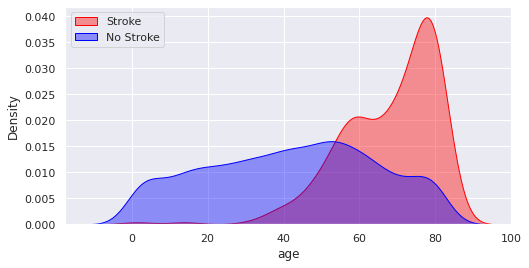

In [10]:
plt.figure(figsize=(8, 4))
ax = sns.kdeplot(df_stroke['age'], shade=True, color='red', alpha=0.4, label='Stroke')
ax = sns.kdeplot(df_nostroke['age'], shade=True, color='blue', alpha=0.4, label='No Stroke')
ax.legend(loc='upper left')
plt.show()

This distribution shows us that age is an **important factor** when analysing strokes. You are more likely to suffer a stroke if you are **older**.

#### Average Glucose Level Distribution

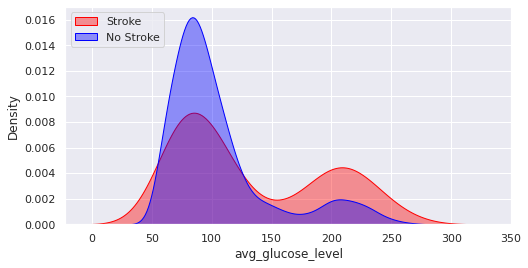

In [11]:
plt.figure(figsize=(8, 4))
ax = sns.kdeplot(df_stroke['avg_glucose_level'], shade=True, color='red', alpha=0.4, label='Stroke')
ax = sns.kdeplot(df_nostroke['avg_glucose_level'], shade=True, color='blue', alpha=0.4, label='No Stroke')
ax.legend(loc='upper left')
plt.show()

#### BMI Distribution

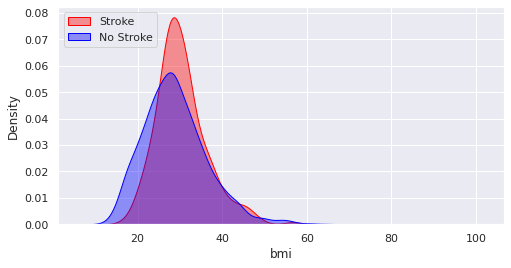

In [12]:
plt.figure(figsize=(8, 4))
ax = sns.kdeplot(df_stroke['bmi'], shade=True, color='red', alpha=0.4, label='Stroke')
ax = sns.kdeplot(df_nostroke['bmi'], shade=True, color='blue', alpha=0.4, label='No Stroke')
ax.legend(loc='upper left')
plt.show()

### 3.2 Visualization of Categoric Variables

Defining a function to calculate percentage of `stroke` and `no_stroke` in each category:

In [13]:
def percentage_df(df_stroke, df_nostroke, col_name):
    df_perc = pd.DataFrame(df_stroke[col_name].value_counts() / len(df_stroke) * 100)\
                           .rename(columns={col_name: 'Stroke'})
    df_perc['No Stroke'] = df_nostroke[col_name].value_counts() / len(df_nostroke) * 100
    df_perc = df_perc.reset_index().rename(columns={'index': col_name})
    return df_perc

Defining a function to plot the comparison between categoric variables:

In [14]:
def plot_comparison(percentage_df, col_name):
    melted_df = percentage_df.melt(id_vars=col_name).rename(columns={'value': 'Percentage', 'variable': 'Type'})
    sns.barplot(data=melted_df, x=col_name, y='Percentage', hue='Type', palette=['red', 'blue'], alpha=0.6);

#### Work Type

In [15]:
work_type = percentage_df(df_stroke, df_nostroke, 'work_type')
work_type

,work_type,Stroke,No Stroke
0,Private,59.839357,57.107591
1,Self-employed,26.104418,15.511212
2,Govt_job,13.253012,12.836865
3,children,0.803213,14.091751


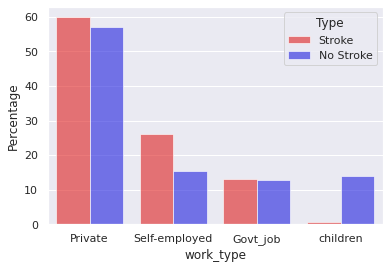

In [16]:
plot_comparison(work_type, 'work_type')

#### Gender

In [17]:
gender_type = percentage_df(df_stroke, df_nostroke, 'gender')
gender_type

,gender,Stroke,No Stroke
0,Female,56.626506,58.691627
1,Male,43.373494,41.287801


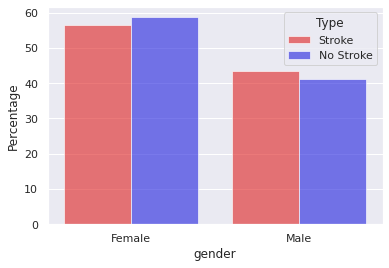

In [18]:
plot_comparison(gender_type, 'gender')

#### Hypertension

In [19]:
hypertension = percentage_df(df_stroke, df_nostroke, 'hypertension')
hypertension

,hypertension,Stroke,No Stroke
0,0,73.493976,91.11294
1,1,26.506024,8.88706


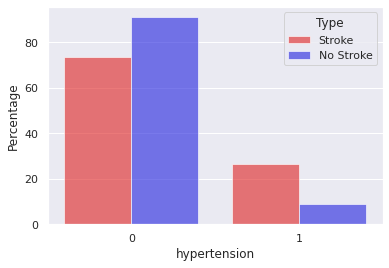

In [20]:
plot_comparison(hypertension, 'hypertension')

#### Heat Disease

In [21]:
heart_disease = percentage_df(df_stroke, df_nostroke, 'heart_disease')
heart_disease

,heart_disease,Stroke,No Stroke
0,0,81.124498,95.289035
1,1,18.875502,4.710965


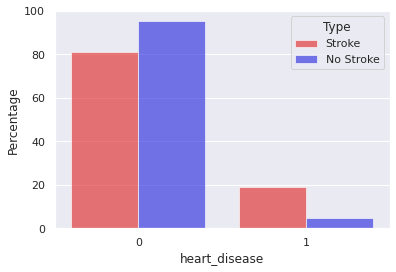

In [22]:
plot_comparison(heart_disease, 'heart_disease')

#### Ever Married

In [23]:
ever_married = percentage_df(df_stroke, df_nostroke, 'ever_married')
ever_married

,ever_married,Stroke,No Stroke
0,Yes,88.353414,64.451759
1,No,11.646586,35.548241


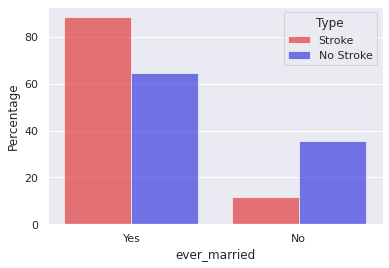

In [24]:
plot_comparison(ever_married, 'ever_married')

#### Residence Type

In [25]:
residence_type = percentage_df(df_stroke, df_nostroke, 'Residence_type')
residence_type

,Residence_type,Stroke,No Stroke
0,Urban,54.216867,50.627443
1,Rural,45.783133,49.372557


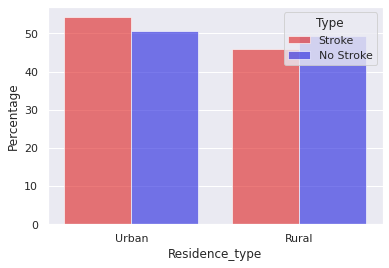

In [26]:
plot_comparison(residence_type, 'Residence_type')

#### Smoking Status

In [27]:
smoking_status = percentage_df(df_stroke, df_nostroke, 'smoking_status')
smoking_status

,smoking_status,Stroke,No Stroke
0,never smoked,36.144578,37.070562
1,formerly smoked,28.112450,16.766098
2,Unknown,18.875502,30.796132
3,smokes,16.867470,15.367208


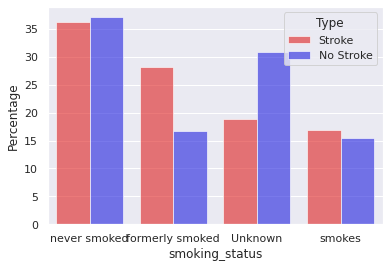

In [28]:
plot_comparison(smoking_status, 'smoking_status')

## 4. Pre Processing
___

### 4.1 Encoding Categorical Variables

#### Label Enconding

In [29]:
# Label Encoding
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1, 'Other': -1})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})
df['smoking_status'] = df['smoking_status'].replace({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown': -1})

#### One Hot Enconding

In [30]:
df = pd.get_dummies(df, columns=['work_type'], prefix='work', prefix_sep=':', dtype=int)

In [31]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work:Govt_job,work:Never_worked,work:Private,work:Self-employed,work:children
0,9046,0,67.0,0,1,1,1,228.69,36.60,1,1,0,0,1,0,0
1,51676,1,61.0,0,0,1,0,202.21,31.14,0,1,0,0,0,1,0
2,31112,0,80.0,0,1,1,0,105.92,32.50,0,1,0,0,1,0,0
3,60182,1,49.0,0,0,1,1,171.23,34.40,2,1,0,0,1,0,0
4,1665,1,79.0,1,0,1,0,174.12,24.00,0,1,0,0,0,1,0


### 4.2 Train Test Split

We'll be using **70%** of our dataset for **training** and **30%** for **testing**

In [38]:
# Selecting Features and Target
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

# Splitting in Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)
print(f"> {len(X_train)} samples for training and {len(X_test)} for testing")

> 3577 samples for training and 1533 for testing


## 5. Model Testing
___

### Creating Pipelines for each model

In [39]:
perceptron_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('Perceptron', Perceptron(tol=1e-3, random_state=42))])
svm_pipeline = Pipeline(steps = [('scaler', StandardScaler()),('SVM', SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scaler', StandardScaler()),('LogisticRegression', LogisticRegression(random_state=42))])
knn_pipeline = Pipeline(steps = [('scaler', StandardScaler()),('KNN', KNeighborsClassifier(n_neighbors=42))])
bayes_pipeline = Pipeline(steps = [('scaler', StandardScaler()),('Bayes', GaussianNB())])
rf_pipeline = Pipeline(steps = [('scaler', StandardScaler()),('RandomForest', RandomForestClassifier(class_weight='balanced', random_state=42))])

### Defining a function to test our models

For each of the pipelines, our function will do the following:
- 5 fold Cross-Validation on Training Data
- Measure Accuracy on Test Data
- Classification Report

In [42]:
def test_models(pipelines, X_train, y_train, X_test, y_test):
    cv_train = {}
    acc_test = {}
    cr = {}
    for pipe in pipelines:
        model_name = pipe.steps[-1][0]
        # 5-fold cross validation on training data
        cv_train[model_name] = cross_val_score(pipe, X_train, y_train, cv=10, scoring='accuracy').mean()
        # Accuracy on test data
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        acc_test[model_name] = accuracy_score(y_test, pred)
        # Classification report
        cr[model_name] = classification_report(y_test, pred, zero_division=0)
    
    # Print scores
    print("5 fold Cross-Validation on Training Data:")
    for model, cv_score in cv_train.items():
        print(f"- {model}: {cv_score:.6f}")
    print("\nAccuracy on Test Data:")
    for model, acc in acc_test.items():
        print(f"- {model}: {acc:.6f}")
        
    return cr

### Testing Models

In [43]:
pipelines = [perceptron_pipeline, svm_pipeline, logreg_pipeline, knn_pipeline, bayes_pipeline, rf_pipeline]

cr = test_models(pipelines, X_train, y_train, X_test, y_test)

5 fold Cross-Validation on Training Data:
- Perceptron: 0.909729
- SVM: 0.951357
- LogisticRegression: 0.951357
- KNN: 0.951357
- Bayes: 0.302224
- RandomForest: 0.949401

Accuracy on Test Data:
- Perceptron: 0.947162
- SVM: 0.951076
- LogisticRegression: 0.951729
- KNN: 0.951076
- Bayes: 0.316373
- RandomForest: 0.951076


**Random Forest** and **Logistic Regression** performed the best in both training and test data. Let's take a look at the Classification Report.

In [44]:
print("Random Forest")
print(cr['RandomForest'])
print("\n\nLogistic Regression")
print(cr['LogisticRegression'])

Random Forest
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.50      0.01      0.03        75

    accuracy                           0.95      1533
   macro avg       0.73      0.51      0.50      1533
weighted avg       0.93      0.95      0.93      1533



Logistic Regression
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1458
           1       1.00      0.01      0.03        75

    accuracy                           0.95      1533
   macro avg       0.98      0.51      0.50      1533
weighted avg       0.95      0.95      0.93      1533



As we can see both models fail to identify the class `1` (stroke cases).

What is the problem?
Our dataset is **highly imbalanced**, there are only **249** strokes cases in our whole dataset (**4,87%**). So even a dumb classifier (which predicts only 0) can get a good accuracy score.

Let's try to balance our dataset using SMOTE.

### Oversampling using SMOTE (Synthetic Minority Oversampling Technique)

SMOTE will create synthetic samples for the minority class.

In [45]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE:\n- {sum(y_train == 1)} stroke cases\n- {sum(y_train == 0)} no-stroke cases\n")
print(f"After SMOTE:\n- {sum(y_train_smote == 1)} stroke cases\n- {sum(y_train_smote == 0)} no-stroke cases\n")
print(f"DataFrame shape after SMOTE: {X_train_smote.shape}")

Before SMOTE:
- 174 stroke cases
- 3403 no-stroke cases

After SMOTE:
- 3403 stroke cases
- 3403 no-stroke cases

DataFrame shape after SMOTE: (6806, 14)


In [46]:
pipelines = [perceptron_pipeline, svm_pipeline, logreg_pipeline, knn_pipeline, bayes_pipeline, rf_pipeline]

cr = test_models(pipelines, X_train_smote, y_train_smote, X_test, y_test)

5 fold Cross-Validation on Training Data:
- Perceptron: 0.820166
- SVM: 0.899949
- LogisticRegression: 0.861164
- KNN: 0.874971
- Bayes: 0.608142
- RandomForest: 0.961662

Accuracy on Test Data:
- Perceptron: 0.835616
- SVM: 0.859100
- LogisticRegression: 0.849315
- KNN: 0.817352
- Bayes: 0.272668
- RandomForest: 0.917156


**RandomForest** and **LogisticRegression** had the best results again. Let's take a look at the Classification Report.

In [47]:
print("Random Forest")
print(cr['RandomForest'])
print("\n\nLogistic Regression")
print(cr['LogisticRegression'])

Random Forest
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1458
           1       0.18      0.20      0.19        75

    accuracy                           0.92      1533
   macro avg       0.57      0.58      0.57      1533
weighted avg       0.92      0.92      0.92      1533



Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.86      0.92      1458
           1       0.17      0.55      0.26        75

    accuracy                           0.85      1533
   macro avg       0.57      0.71      0.59      1533
weighted avg       0.93      0.85      0.88      1533



The results after SMOTE are better than before.

But not good enough...

### Grid Search

Let's try to find the best hyperparameters for the RandomForest and LogisticRegression models.

In [48]:
def plot_cm(expected, predicted):
    cm = confusion_matrix(expected, predicted)
    plt.figure(figsize=(6, 6))
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
    plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits

               precision    recall  f1-score   support

           0       0.96      0.90      0.93      1458
           1       0.13      0.29      0.18        75

    accuracy                           0.87      1533
   macro avg       0.55      0.60      0.56      1533
weighted avg       0.92      0.87      0.89      1533



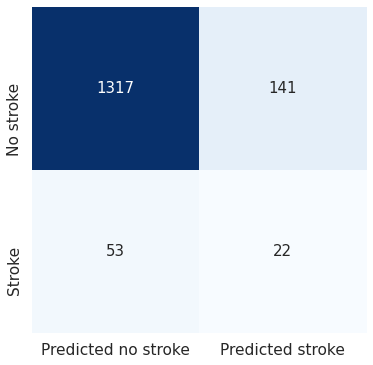

In [49]:
# RandomForest
param_grid = {
  'RandomForest__n_estimators': np.arange(2, 100),
  'RandomForest__min_samples_split': np.arange(8, 51),
  'RandomForest__min_samples_leaf': np.arange(1, 31),
  'RandomForest__max_depth': np.arange(2, 20),
  'RandomForest__max_samples': np.arange(0.1, 1, 0.1)
}

random_grid_search = RandomizedSearchCV(estimator=rf_pipeline,
                                        param_distributions=param_grid,
                                        n_iter=100,
                                        scoring='f1_weighted',
                                        n_jobs=-1, verbose=2, random_state=42)

random_grid_search.fit(X_train_smote, y_train_smote)

pred = random_grid_search.best_estimator_.predict(X_test)
print("\n", classification_report(y_test, pred))
plot_cm(y_test, pred)


               precision    recall  f1-score   support

           0       0.97      0.86      0.92      1458
           1       0.17      0.55      0.26        75

    accuracy                           0.85      1533
   macro avg       0.57      0.71      0.59      1533
weighted avg       0.93      0.85      0.88      1533



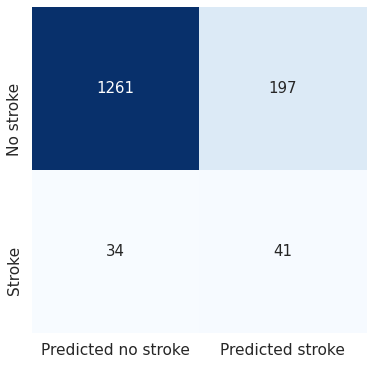

In [50]:
# Logistic Regression
param_grid = {
    'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

logreg_grid_search = GridSearchCV(estimator=logreg_pipeline,
                                  param_grid=param_grid)

logreg_grid_search.fit(X_train_smote, y_train_smote)

pred = logreg_grid_search.best_estimator_.predict(X_test)
print("\n", classification_report(y_test, pred))
plot_cm(y_test, pred)